In [1]:
# !pip install gensim==3.8.8
# !pip install wordcloud
# !pip install nltk
# import nltk
# nltk.download('wordnet')
# !pip install Cython
# !pip uninstall gensim -Y
# !pip install gensim 
# !pip uninstall gensim -y
# !pip install -U gensim
# !pip install rake-nltk
# !pip install fasttext


In [2]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
# from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
# nltk.download("vader_lexicon")
# nltk.download('stopwords')
# nltk.download('punkt')
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec
# import gensim
import fasttext
from sklearn.decomposition import LatentDirichletAllocation, NMF

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from rake_nltk import Rake
from sklearn.manifold import TSNE

import yake

2024-07-24 09:01:55.624144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Objective

- This Mental Health Dataset contains conversations between users and experienced psycholigists. 
- The dataset allows the developers to utilize advanced NLP methids to derive meanful insights and represeatations from the contain, enhanching the development of AI models to focus on mental health advice and guidance.
- This could be a sentiment analysis and base on the analysis, we can train use generative AI to give generate answer to the questions.


## Table of content

1. Preprocessing
    - Text cleaning: remove irrelevant characters, URLs, and special symbols from the text data.
    - Tokenization: split the text into tokens.
    - Stopword removal: remove common stopwords that do not contribute significatly to the meaning of the text.
    - Lemmatization: convert words to their base or root form to ensure consistency.
2. Word Embeddings
    - Word2Vec: to generate word embeddings, capturing semantic relationships between wrods in the conversations.
    - GloVe: to generate word embeddings, focusing on capturing the global context of words.
    - FastText: to generate word embedding and find the semantic similarities, capturing subword information and handling out-of-vocabulary words effectively.
3. Model training
    - Sentiment Analysis: train models to classifiy the sentiment of the conversations.
    - Topic Modeling: use techniques like LDA to identify prevalent topics in the conversations (This could be helpful to classify the main topics for each mental health conversation)
    - Text classification: develop models to classify the type of mental health issues or advice based on the conversation content.

4. Visualization
    - t-SNE or PCA: to visualize the word embeddings in a 2D or 3D space, showing the clustering of semantically similar or phrases.

5. Evaluation:
    - Measure model performance (confusion-matrix)

6. Qualitative analysis:
    - Contextual meeaning: analyze the results to ensure that the embeddings capture meaningful relationships and context within the mental health conversations. 
    - Validate the model by a new conversation.


## 1. Preprocessing

#### 1.a. Text cleaning

In [3]:
data = pd.read_csv(''.join([str(Path.cwd()),"/4_Mental_heatlh.csv"]))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [4]:

def clean_texts(text):
    text = str(text)
    text = re.sub('[^a-zA-z]', ' ', text)
    text = text.lower()
    text = fasttext.tokenize(text) 
    # text = text.split()       
    text = ' '.join(text)
    return text

data['ProcessedContext'] = data.Context.apply(clean_texts)
data['ProcessedResponse'] = data.Response.apply(clean_texts)
data


,Context,Response,ProcessedContext,ProcessedResponse
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",i m going through some things with my feelings...,if everyone thinks you re worthless then maybe...
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",i m going through some things with my feelings...,hello and thank you for your question and seek...
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,i m going through some things with my feelings...,first thing i d suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,i m going through some things with my feelings...,therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,i m going through some things with my feelings...,i first want to let you know that you are not ...
...,...,...,...,...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...,my grandson s step mother sends him to school ...,absolutely not it is never in a child s best i...
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...,my boyfriend is in recovery from drug addictio...,i m sorry you have tension between you and you...
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit...",the birth mother attempted suicide several tim...,the true answer is no one can really say with ...
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...,i think adult life is making him depressed and...,how do you help yourself to believe you requir...


### 1.b. Tokenization

We can actually combine this step together with part 1.c. by fastest. Or we can tokenize them seperately

In [5]:
# word-index dict
# tokenizer = Tokenizer(num_words=5000) # top 5000 frequent words
# tokenizer.fit_on_texts(data.ProcessedContext)
# word_index = tokenizer.word_index
# vocab_size = len(word_index)+1 # added 1, because index of first word starts from 1
# print("There are {} unique words".format(len(word_index)))
# print("================================")
# print(word_index)
# print("================================")
# print("Vocabulary_size:", vocab_size)

### 1.c. Removing stop words amd lematization

In [6]:
lemmatizer = WordNetLemmatizer()
sw = set(STOPWORDS)

def removing_stopwords(x):
    text = fasttext.tokenize(x)
    for j in range(len(text)):
        if text[j] in sw:
            text[j] = ''
        else:
            text[j] = lemmatizer.lemmatize(text[j])
    text = ' '.join(text)
    return text

data['ProcessedContext'] = data.ProcessedContext.apply(removing_stopwords)
data['ProcessedResponse'] = data.ProcessedResponse.apply(removing_stopwords)
data

,Context,Response,ProcessedContext,ProcessedResponse
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",m going thing feeling barely sleep ...,everyone think re worthless maybe need fi...
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",m going thing feeling barely sleep ...,hello thank question seeking advice fee...
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,m going thing feeling barely sleep ...,first thing d suggest getting sleep need ...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,m going thing feeling barely sleep ...,therapy essential feeling depressed wort...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,m going thing feeling barely sleep ...,first want let know alone feeling ...
...,...,...,...,...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...,grandson s step mother sends school pink ...,absolutely never child s best interest u...
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...,boyfriend recovery drug addiction recentl...,m sorry tension bf relationship mean t...
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit...",birth mother attempted suicide several time ...,true answer one really say certainty var...
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...,think adult life making depressed often s...,help believe require offer r...


## 2. Word Ebbeddings / Normalization


Word2Vec using gensim is not working \
Using fasttest instead \
We are going to train and extract the similar words later for visualization.

In [68]:
data.ProcessedContext.to_csv("ProcessedContext.csv")
data.ProcessedResponse.to_csv("ProcessedResponse.csv")

modelContext = fasttext.train_unsupervised("ProcessedContext.csv", model = 'skipgram')
modelContext.save_model('ProcessedContext.bin')

modelResponse = fasttext.train_unsupervised("ProcessedResponse.csv", model = 'skipgram')
modelResponse.save_model('ProcessedResponse.bin')

Read 0M words
Number of words:  1786
Number of labels: 0
Progress: 100.0% words/sec/thread:   84216 lr:  0.000000 avg.loss:  2.567767 ETA:   0h 0m 0s
Read 0M words
Number of words:  4585
Number of labels: 0
Progress: 100.0% words/sec/thread:   70405 lr:  0.000000 avg.loss:  2.365558 ETA:   0h 0m 0s



## 3. Model Training

### 3.a. Topic Modeling
We are trying to classify the questions into groups to find the groups of the patients' different health issues.

In [9]:
##### Turn context data into vector
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data.ProcessedContext)

##### Using LDA
lda = LatentDirichletAllocation(n_components=5, random_state=3)
lda_topics = lda.fit_transform(X)
lda_topics

array([[0.00778656, 0.00778194, 0.96876103, 0.00786186, 0.00780861],
       [0.00778656, 0.00778194, 0.96876103, 0.00786186, 0.00780861],
       [0.00778656, 0.00778194, 0.96876103, 0.00786186, 0.00780861],
       ...,
       [0.005003  , 0.4142047 , 0.51922784, 0.05660891, 0.00495555],
       [0.00586575, 0.97658886, 0.00593543, 0.00577848, 0.00583148],
       [0.00965363, 0.00959678, 0.00964626, 0.00960705, 0.96149629]])

### Display topics

In [10]:
# Display the Topics
def display_topics(model, feature_names, num_top_words):
    result = []
    for topic_idx, topic in enumerate(model.components_):
        r = " ".join([feature_names[i] for i in topic.argsort()[:num_top_words - 1:1]])
        result.append(r)
    return result

num_top_words = 300
tf_feature_names= vectorizer.get_feature_names_out()
topics = display_topics(lda, tf_feature_names, num_top_words)
topics

['fridge beer counted discussing battle replying discovered board limit snore snapped slurred vodka giveaway consumption honesty regard timing luckily temptation surprised hooking loathing tall approached waiting finished originally answering window lent tie replaced thanksgiving conduct resist definite respectfully misery sake established considering remain pace acknowledged proposal confessed release estimate bankrupt eaten meaning improving finger dumb plus material fund envious flying mall cashier pumped bet clinging happier conflict poodle curl avoiding oriented share consoled separating fallen faithful unfaithful unsettling resolution dying wedding led stepdaughter sixty pansexual haunting forgiveness grateful betrayal condition spurt arm pure scratch earring punch hormone destructive thigh bite confront lending november yes april borrow debt disappear logically breast lifetime insomniac original sob trail borrowing pathological compulsively epilepsy simple gamble maintain guess 

### Assign topics


In [12]:
def get_dominant_topic(row):
    return np.argmax(row)
    # return row.idxmax()
    
topic_list = [get_dominant_topic(i) for i in lda_topics]
data["Topic"]  = topic_list
data


,Context,Response,ProcessedContext,ProcessedResponse,Topic
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",m going thing feeling barely sleep ...,everyone think re worthless maybe need fi...,2
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",m going thing feeling barely sleep ...,hello thank question seeking advice fee...,2
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,m going thing feeling barely sleep ...,first thing d suggest getting sleep need ...,2
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,m going thing feeling barely sleep ...,therapy essential feeling depressed wort...,2
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,m going thing feeling barely sleep ...,first want let know alone feeling ...,2
...,...,...,...,...,...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...,grandson s step mother sends school pink ...,absolutely never child s best interest u...,4
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...,boyfriend recovery drug addiction recentl...,m sorry tension bf relationship mean t...,1
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit...",birth mother attempted suicide several time ...,true answer one really say certainty var...,2
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...,think adult life making depressed often s...,help believe require offer r...,1


### WordCloud for each topics

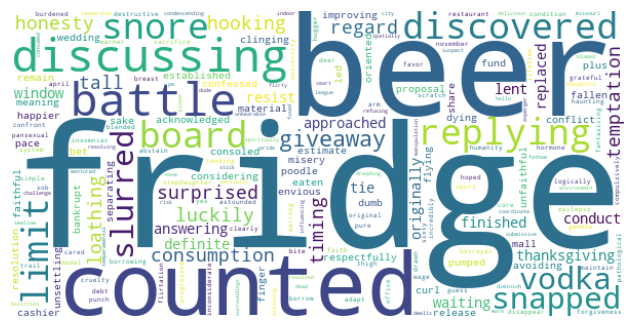

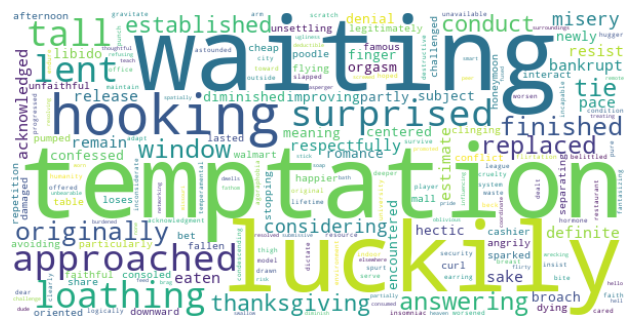

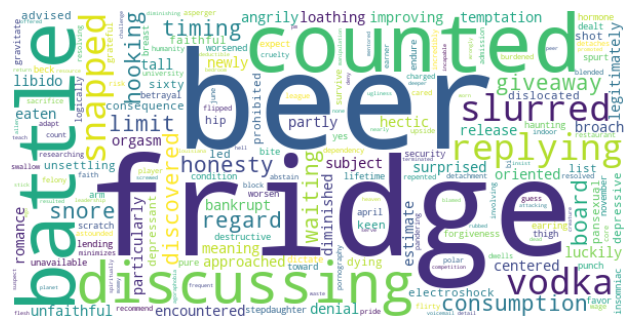

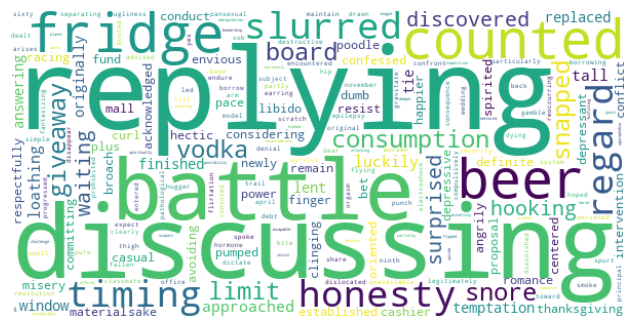

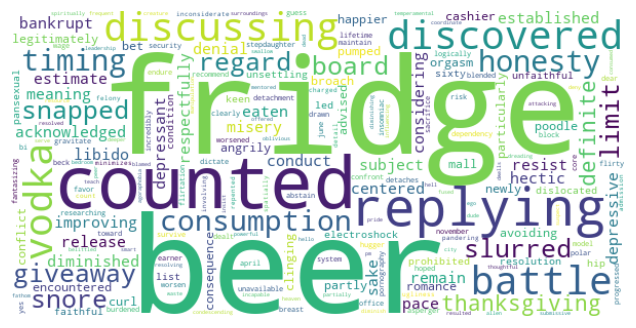

In [13]:
for i in topics:
    wordcloud = WordCloud(width=600, height=300, background_color ='white').generate(i)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    # plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.axis('off')
    plt.show()

### WordCloud for each topic's response

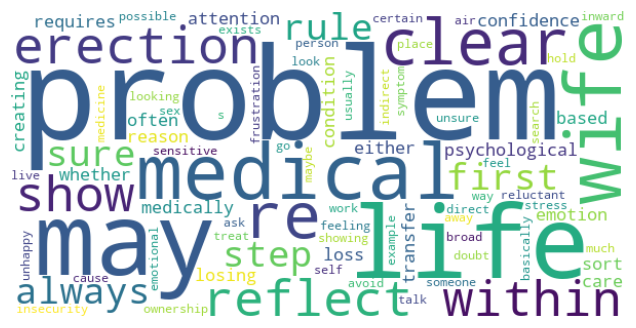

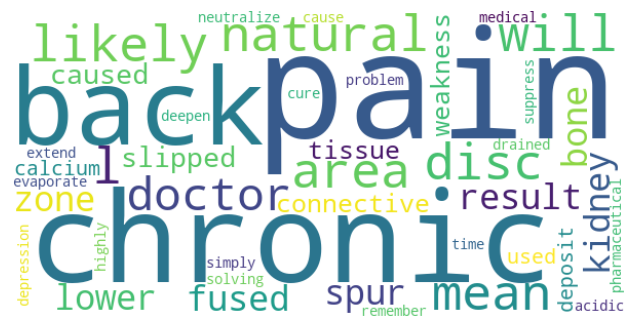

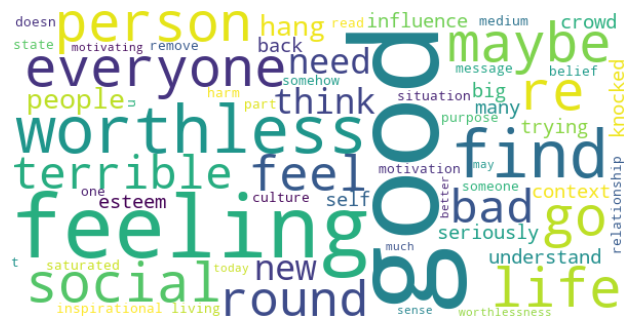

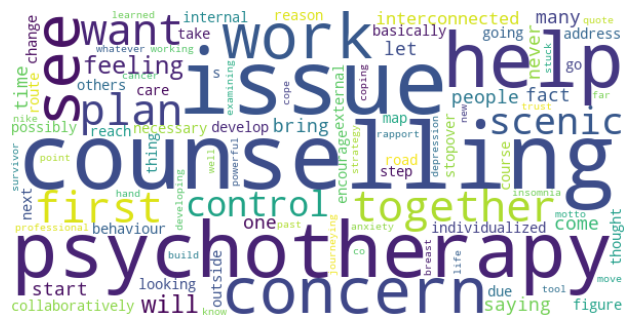

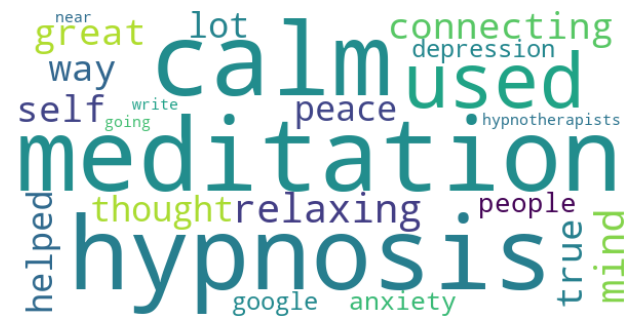

In [14]:
topic1 = data[data.Topic == 0].ProcessedResponse
topic2 = data[data.Topic == 1].ProcessedResponse
topic3 = data[data.Topic == 2].ProcessedResponse
topic4 = data[data.Topic == 3].ProcessedResponse
topic5 = data[data.Topic == 4].ProcessedResponse

responseTopic = []
responseTopic.append(list(topic1))
responseTopic.append(list(topic2))
responseTopic.append(list(topic3))
responseTopic.append(list(topic4))
responseTopic.append(list(topic5))

for i in responseTopic:
    wordcloud = WordCloud(width=600, height=300, background_color ='white').generate(i[0])
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    # plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.axis('off')
    plt.show()


WordClouds for both do not so helpful categorized words to help identify the different mental problems. We can try analyze further.


### 3.b. Sentiment analysis

In [192]:
sentiments = SentimentIntensityAnalyzer()
pos = [sentiments.polarity_scores(i)['pos'] for i in topics]
neg = [sentiments.polarity_scores(i)['neg'] for i in topics]
neutral = [sentiments.polarity_scores(i)['neu'] for i in topics]
pos, neg, neutral

([0.239, 0.241, 0.205, 0.197, 0.188],
 [0.249, 0.234, 0.272, 0.267, 0.292],
 [0.513, 0.525, 0.523, 0.536, 0.519])

We can see that all topics have approximately the same score for all sentiment categories. All topics also more neutrals than positive or negative. Therefore, the scores do not tell us much the discrepancy between groups.  \
We can try extracting keywords for each topic.


### 3.b. Using Keyword extraction from context 

In [16]:
topic1 = data[data.Topic == 0].Context
topic2 = data[data.Topic == 1].Context
topic3 = data[data.Topic == 2].Context
topic4 = data[data.Topic == 3].Context
topic5 = data[data.Topic == 4].Context

contextTopic = []
contextTopic.append(list(topic1))
contextTopic.append(list(topic2))
contextTopic.append(list(topic3))
contextTopic.append(list(topic4))
contextTopic.append(list(topic5))


### TfidfVectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

for i in range(len(topics)):
    tfidf = TfidfVectorizer()
    tfidf.fit_transform(''.join(contextTopic[i]).split())
    print ("Topic", i ,':', tfidf.get_feature_names_out()[np.argsort(tfidf.idf_)[-10:]])

Topic 0 : ['worse' 'outhe' 'states' 'distant' 'begun' 'masturbating' 'distanced'
 'ignores' 'hung' 'walked']
Topic 1 : ['dbt' 'man' 'topamax' 'deficient' 'louder' 'lose' 'dependent'
 'apologizes' 'lamictal' 'medications']
Topic 2 : ['shows' 'heated' 'side' 'disagreeing' 'bestfriend' 'may' 'teachable'
 'medium' 'supporting' 'happiness']
Topic 3 : ['each' 'flirted' 'friendly' 'friends' 'kissed' 'fun' 'gained' 'sit'
 'common' 'park']
Topic 4 : ['uk' 'shouldn' 'criticizes' 'understanding' 'unexpected' 'nanny'
 'uniform' 'condone' 'show' 'games']


### Rapid Keyword Extraction (RAKE)

In [18]:
for i in range(len(topics)):
    r = Rake()
    r.extract_keywords_from_text(''.join(contextTopic[i]))
    keywords = r.get_ranked_phrases_with_scores()

    # Print the extracted keywords and their scores
    for score, kw in keywords[:4]:
        print( "Topic:", i,"    Keyword:", kw )

Topic: 0     Keyword: grandma passed away 5 months ago
Topic: 0     Keyword: grandma passed away 5 months ago
Topic: 0     Keyword: five years roughly ten times
Topic: 0     Keyword: five years roughly ten times
Topic: 1     Keyword: strict 48 hour cancellation policy
Topic: 1     Keyword: strict 48 hour cancellation policy
Topic: 1     Keyword: pretty intense mood swings throughout
Topic: 1     Keyword: pretty intense mood swings throughout
Topic: 2     Keyword: envelope containing several hundred dollars
Topic: 2     Keyword: envelope containing several hundred dollars
Topic: 2     Keyword: envelope containing several hundred dollars
Topic: 2     Keyword: type one diabetic two years ago
Topic: 3     Keyword: accusatory manner becomes unbearably frustrating
Topic: 3     Keyword: accusatory manner becomes unbearably frustrating
Topic: 3     Keyword: suffering severe abandonment issues stemming
Topic: 3     Keyword: suffering severe abandonment issues stemming
Topic: 4     Keyword: low 

### Yet Another Keyword Extractor (YAKE)

In [46]:
contextKeywords = []
for i in range(len(topics)):
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(''.join(list(contextTopic[i])))
    r = [kw[0] for kw in keywords]
    contextKeywords.append(r)
    print("Topic:", i, r)

Topic: 0 ['feel', 'years', 'sex', 'therapist', 'friends', 'anxiety', 'told', 'year', 'friend', 'girlfriend', 'love', 'relationship', 'depression', 'stop', 'boyfriend', 'husband', 'Disorder', 'married', 'past', 'men']
Topic: 1 ['feel', 'years', 'years ago', 'child', 'time', 'people', 'boyfriend', 'n’t', 'year', 'parents', 'daughter', 'life', 'dad', 'husband', 'past', 'night', 'school', 'afraid', 'things', 'drinking']
Topic: 2 ['feel', 'time', 'love', 'feeling', 'times', 'couple therapy sessions', 'relationship', 'normal', 'years', 'people', 'couple therapy', 'therapy', 'things', 'therapy sessions', 'talk', 'friends', 'day', 'days', 'told', 'feelings']
Topic: 3 ['issues to address', 'counseling', 'issues', '’ve', 'long history', 'history', 'address', 'breast cancer survivor', 'history of depression', 'history of sexual', 'end counseling sessions', 'years', 'end counseling', 'happily married', 'sexual abuse', 'address in counseling', 'lifetime insomniac', 'breast cancer', 'cancer survivor

YAKE seems to classify the texts very well. 
- The first topic could relate to couple relationship/marriage
- The second could be relating to domestic problems like parents and children and teenage early itimacy. 
- The third is more about self-depression, isolation, and unconfident. 
- The fourth sounds like domestic abuse.
- The last one is more about being lonely, sad but not very serious.

In [190]:
responseKeywords = []
for i in range(len(topics)):
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(''.join(list(responseTopic[i])))
    r = [kw[0] for kw in keywords]
    responseKeywords.append(r)
    print("Topic:", i, r)

Topic: 0 ['thing make feel', 'feel people feel', 'relationship partner feel', 'make feel comfortable', 'make partner feel', 'time good time', 'fear make feel', 'client therapist relationship', 'feel important people', 'care time feel', 'make good therapist', 'people life time', 'good time conversation', 'person time make', 'thing start feel', 'care make feel', 'mental health professional', 'fear thing make', 'relationship sex therapist', 'question good don']
Topic: 1 ['time good therapist', 'make good marriage', 'feel feel relationship', 'time people don', 'feel parent don', 'make feel time', 'feel relationship good', 'thing make feel', 'life make feel', 'good relationship child', 'time talk relationship', 'make feel good', 'child important child', 'good thing relationship', 'relationship parent child', 'thing relationship parent', 'find therapist feel', 'relationship find time', 'relationship parent feeling', 'time talk people']
Topic: 2 ['make feel good', 'thing make feel', 'make per

## 4. t-SNE visualization

### Getting a list of similar words in the context based on extracted keywords

In [69]:
modelContext = fasttext.load_model('ProcessedContext.bin')
modelResponse = fasttext.load_model('ProcessedResponse.bin')

### For context

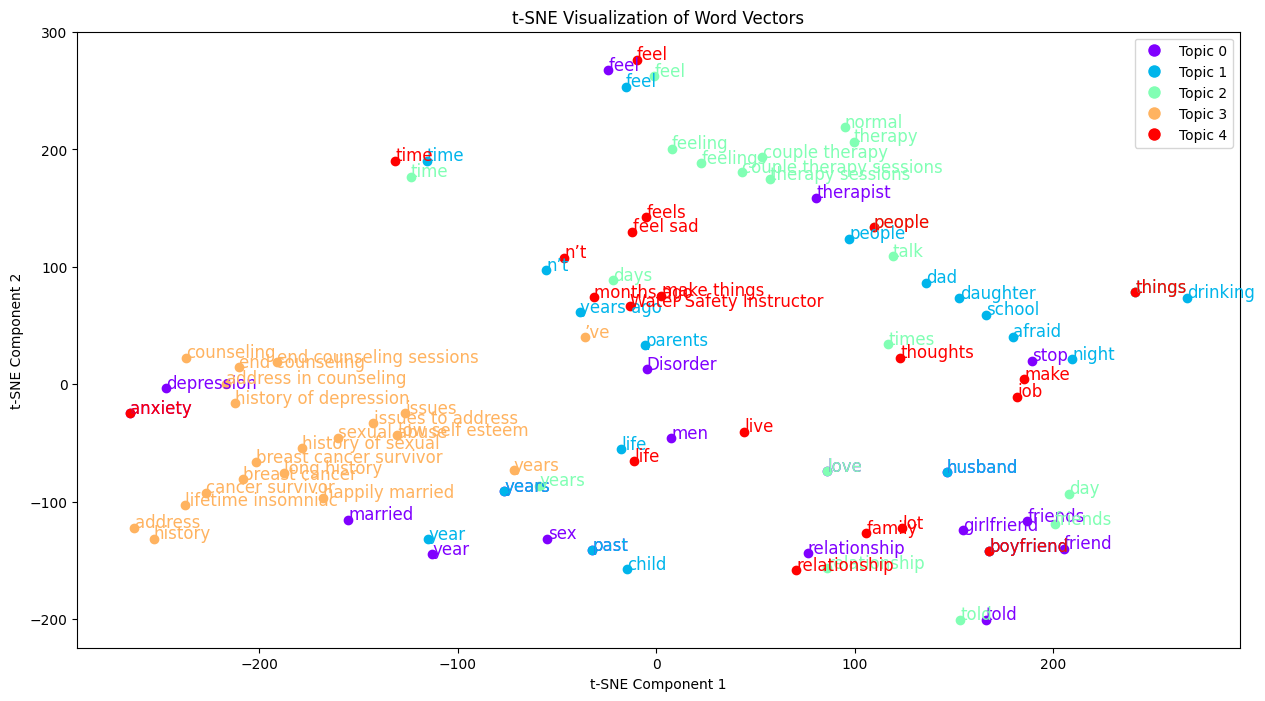

In [193]:
# Collect all word vectors and corresponding labels
all_word_vectors = []
all_words = []
all_labels = []

for j in range(len(contextKeywords)):
    word_vectors = [modelContext.get_word_vector(word) for word in contextKeywords[j]]
    all_word_vectors.extend(word_vectors)
    all_words.extend(contextKeywords[j])
    all_labels.extend([j] * len(contextKeywords[j]))

# Apply t-SNE to the combined word vectors
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(np.array(all_word_vectors))

colors = plt.cm.tab20(np.linspace(0, 1, len(contextKeywords)))
# Generate colors for different lists
colors = plt.cm.rainbow(np.linspace(0, 1, len(contextKeywords)))

# Plot all word vectors with different colors
plt.figure(figsize=(15, 8))
for i, (word, label) in enumerate(zip(all_words, all_labels)):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=colors[label], label=label if i == 0 else "")
    plt.text(X_tsne[i, 0] + 0.1, X_tsne[i, 1], word, fontsize=12, color=colors[label])

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(contextKeywords))]
labels = [f'Topic {i}' for i in range(len(contextKeywords))]
plt.legend(handles, labels, loc='best')

plt.title('t-SNE Visualization of Word Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### For response

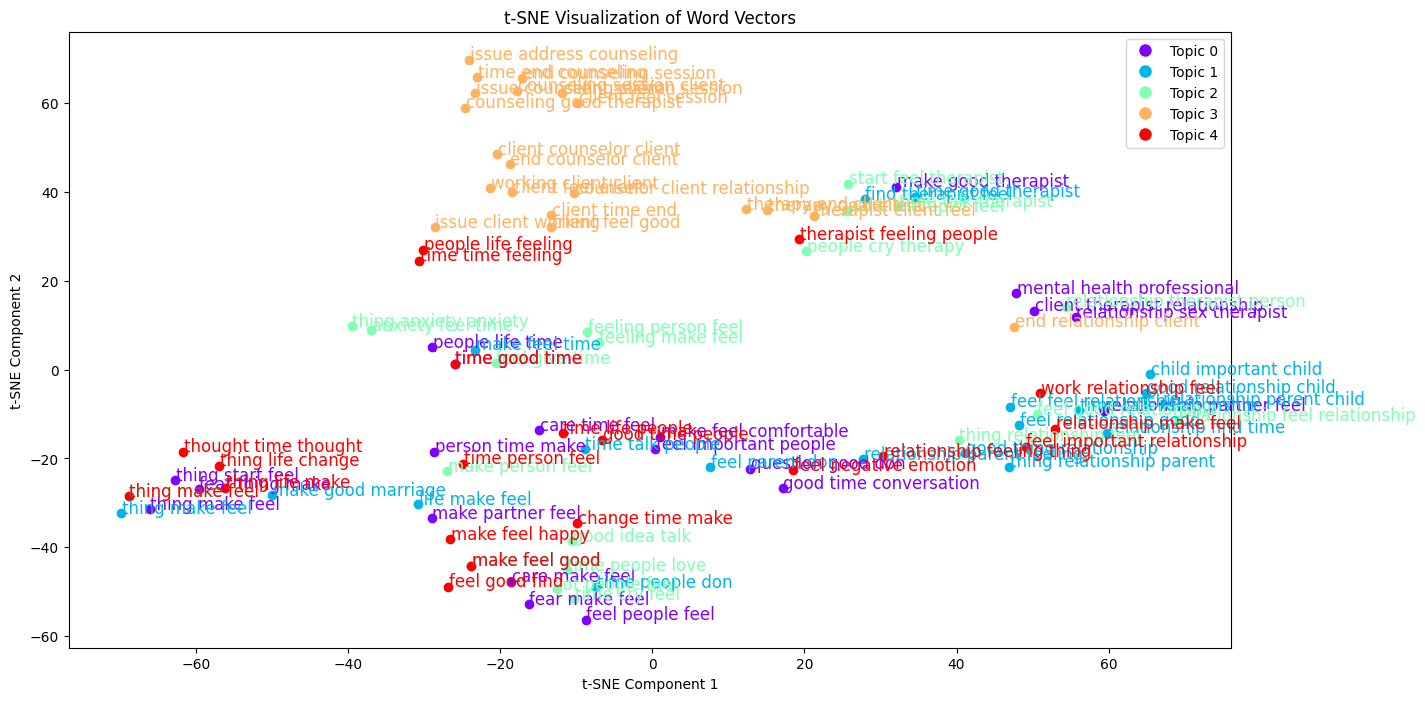

In [191]:
# Collect all word vectors and corresponding labels
all_word_vectors = []
all_words = []
all_labels = []

for j in range(len(responseKeywords)):
    word_vectors = [modelContext.get_word_vector(word) for word in responseKeywords[j]]
    all_word_vectors.extend(word_vectors)
    all_words.extend(responseKeywords[j])
    all_labels.extend([j] * len(responseKeywords[j]))

# Apply t-SNE to the combined word vectors
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(np.array(all_word_vectors))

colors = plt.cm.tab20(np.linspace(0, 1, len(responseKeywords)))
# Generate colors for different lists
colors = plt.cm.rainbow(np.linspace(0, 1, len(responseKeywords)))

# Plot all word vectors with different colors
plt.figure(figsize=(15, 8))
for i, (word, label) in enumerate(zip(all_words, all_labels)):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=colors[label], label=label if i == 0 else "")
    plt.text(X_tsne[i, 0] + 0.1, X_tsne[i, 1], word, fontsize=12, color=colors[label])

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(responseKeywords))]
labels = [f'Topic {i}' for i in range(len(responseKeywords))]
plt.legend(handles, labels, loc='best')

plt.title('t-SNE Visualization of Word Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## 5. Evaluation

- This is an unsupervised NLP dataset in which we do not have the explicit target to train on.
- Topic modeling technique was used to group the questions into different groups that could be useful to distinguish the different responses for each group.
- Although we did not get the explicit seperation between groups, we could use 5 different segments of mental health issues represent for different situations that the patients are in:
    - Group 0: is the group of couples that are in early stages of marriage or couples are having relationship problems. The main advises could be trying to compromise with their partners and have effective conversations to make each other feel better.
    - Group 1: this group appears to be the parenting situations where there exists the conficts between parents and their childern. Children seem to not have good relationships with parents and are under stress both at home and at school; parents seem to not have good childhood which have a significant impact on their children. The advides in this situation are for parents to try and connect with their children by making more time for them, especially they should try to have a more better family to give their kids the best childhood by having a quality relationship with each other.
    - Group 2: group 2 sound more like individuals are under presure because they always compare themself to others so they feel small and unconfident. They have a hard time to express their feeling and talk to someone about what they are going through. All they need is someone to make them feel comfortable to talk to, to make them feel open to express their feeling. This person could be a domestic partner, a friend, or a therapist.
    - Group 3: is the most extreme group. People in this group have experienced sickness, a long history of depression, or domestic abuse. They have lots of issues that they need to address so they need specialists and counseling sessions to have them overcome those issues.
    - Group 4: this group does not need a big attention. They only feel seperated from their social life due to many reasons. All they need is just to calm down, meditate, and connect more with other people, especially with family members and close friends.

- The project does not perfectly categorize the different mental health issues, but it was enough to understand the shared situations patients are going through. We can improve further by collecting data or having labels so that we can train more effeciently. 